<a href="https://colab.research.google.com/github/wesleybeckner/data_science_foundations/blob/main/notebooks/solutions/SOLN_X1_Thinking_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Foundations <br> Extras 1: Thinking Data

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

---

<br>

Today we are going to take our newfound knowledge from the course, and practice how we can leverage data to build predictive models. We'll start with a feature engineering problem on some dummy data. This will get us thinking creatively about problem solving. We will then pivot over to an [Airbnb dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data/code). After performing some general, exploratory data analysis, we will solve the following business case: Airbnb is interested in using historical list prices from their airbnb hosts, to make pricing suggestions to new hosts. How can we use this existing datset to assist with this price listing suggestion?

<br>

---

<br>

<a name='x.0'></a>

## Prepare Environment and Import Data

[back to top](#top)

In [1]:
# basic packages
import pandas as pd
import numpy as np
import random
import copy

# visualization packages
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns; sns.set()
import graphviz 

# stats packages
import scipy.stats as stats
from scipy.spatial.distance import cdist
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

# sklearn preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# sklearn modeling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# sklearn evaluation
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, silhouette_score, calinski_harabasz_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score

## Warm Up

Add aditional feature(s) to X to predict y with a model limited to a linear classification boundary

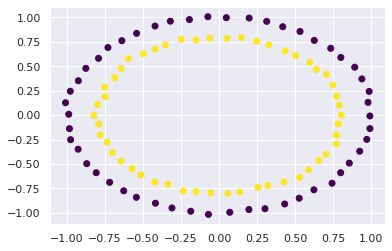

In [2]:
from sklearn.datasets import make_circles
X, y = make_circles(random_state=42, noise=.01)
relabel = dict(zip([0,1,2,3],[0,1,0,1]))
y = np.vectorize(relabel.get)(y)
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis')

In [3]:
X2 = (X**2).sum(axis=1)
X_ = np.hstack((X,X2.reshape(-1,1)))

We can separate:

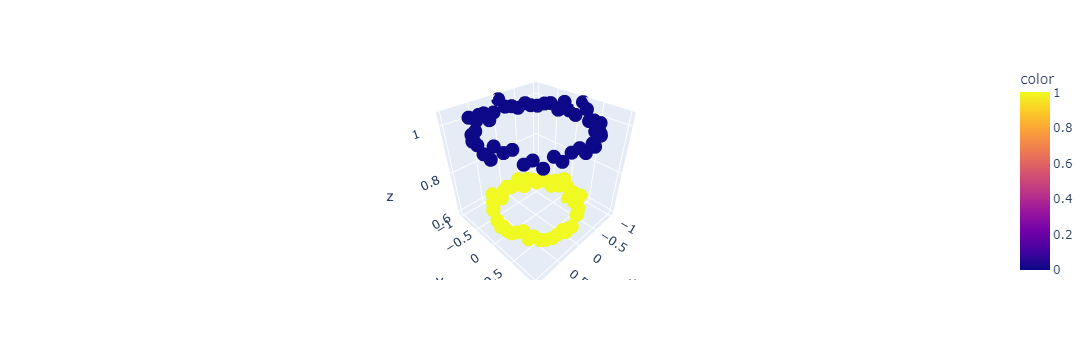

In [4]:
px.scatter_3d(x=X_[:,0], y=X_[:,1], z=X_[:,2], color=y)

and now predict

In [5]:
model = LogisticRegression()
model.fit(X_, y)
y_pred = model.predict(X_)
r2_score(y, y_pred)

1.0

## Build a Baseline

### Exploratory Data Analysis

which columns are numerical, string; which contain nans/nulls; what is the VIF between features

In [6]:
airbnb = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/datasets/main/datasets/airbnb/AB_NYC_2019.csv")

In [7]:
airbnb.shape

(48895, 16)

In [8]:
airbnb.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [9]:
airbnb.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [10]:
airbnb.isnull().sum(axis=0)

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [11]:
airbnb.nunique()

id                                48895
name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

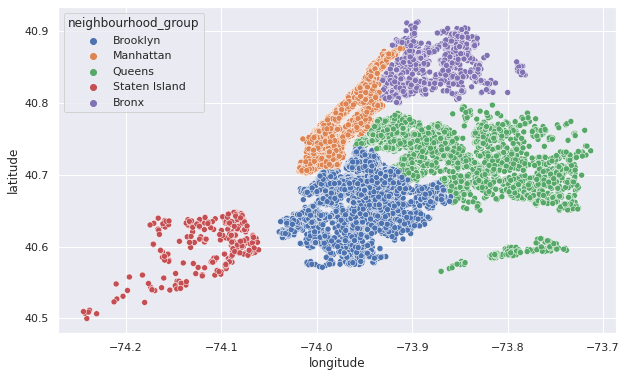

In [12]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=airbnb.longitude,y=airbnb.latitude,hue=airbnb.neighbourhood_group)
plt.ioff()

In [13]:
X = airbnb.copy()

reviews_per_month has some 'nans'

In [14]:
X_num = X.select_dtypes(exclude='object')
X_num.tail()

id   host_id  latitude  longitude  price  minimum_nights  \
48890  36484665   8232441  40.67853  -73.94995     70               2   
48891  36485057   6570630  40.70184  -73.93317     40               4   
48892  36485431  23492952  40.81475  -73.94867    115              10   
48893  36485609  30985759  40.75751  -73.99112     55               1   
48894  36487245  68119814  40.76404  -73.98933     90               7   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
48890                  0                NaN                               2   
48891                  0                NaN                               2   
48892                  0                NaN                               1   
48893                  0                NaN                               6   
48894                  0                NaN                               1   

       availability_365  
48890                 9  
48891                36  
48892                27  
48893                 2  
48894                23

In [15]:
X_num.head()

id  host_id  latitude  longitude  price  minimum_nights  \
0  2539     2787  40.64749  -73.97237    149               1   
1  2595     2845  40.75362  -73.98377    225               1   
2  3647     4632  40.80902  -73.94190    150               3   
3  3831     4869  40.68514  -73.95976     89               1   
4  5022     7192  40.79851  -73.94399     80              10   

   number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                  9               0.21                               6   
1                 45               0.38                               2   
2                  0                NaN                               1   
3                270               4.64                               1   
4                  9               0.10                               1   

   availability_365  
0               365  
1               355  
2               365  
3               194  
4                 0

In [16]:
X_num.describe()

id       host_id      latitude     longitude         price  \
count  4.889500e+04  4.889500e+04  48895.000000  48895.000000  48895.000000   
mean   1.901714e+07  6.762001e+07     40.728949    -73.952170    152.720687   
std    1.098311e+07  7.861097e+07      0.054530      0.046157    240.154170   
min    2.539000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.471945e+06  7.822033e+06     40.690100    -73.983070     69.000000   
50%    1.967728e+07  3.079382e+07     40.723070    -73.955680    106.000000   
75%    2.915218e+07  1.074344e+08     40.763115    -73.936275    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    48895.000000       48895.000000       38843.000000   
mean         7.029962          23.274466           1.373221   
std         20.510550          44.550582           1.680442   
min          1.000000           0.000000           0.010000   
25%          1.000000           1.000000           0.190000   
50%          3.000000           5.000000           0.720000   
75%          5.000000          24.000000           2.020000   
max       1250.000000         629.000000          58.500000   

       calculated_host_listings_count  availability_365  
count                    48895.000000      48895.000000  
mean                         7.143982        112.781327  
std                         32.952519        131.622289  
min                          1.000000          0.000000  
25%                          1.000000          0.000000  
50%                          1.000000         45.000000  
75%                          2.000000        227.000000  
max                        327.000000        365.000000

In [17]:
X.dropna(inplace=True)
X_num = X.select_dtypes(exclude='object')

In [18]:
vif = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]
pd.DataFrame(vif, index=X_num.columns)

0
id                                   2.180074
host_id                              2.836905
latitude                             0.775769
longitude                       425502.981678
price                                1.012423
minimum_nights                       1.039144
number_of_reviews                    2.348200
reviews_per_month                    2.314318
calculated_host_listings_count       1.067389
availability_365                     1.139558

In [19]:
X_num.drop('longitude', axis=1, inplace=True)

/home/wbeckner/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
X_num

id    host_id  latitude  price  minimum_nights  \
0          2539       2787  40.64749    149               1   
1          2595       2845  40.75362    225               1   
3          3831       4869  40.68514     89               1   
4          5022       7192  40.79851     80              10   
5          5099       7322  40.74767    200               3   
...         ...        ...       ...    ...             ...   
48782  36425863   83554966  40.78099    129               1   
48790  36427429  257683179  40.75104     45               1   
48799  36438336  211644523  40.54179    235               1   
48805  36442252  273841667  40.80787    100               1   
48852  36455809   74162901  40.69805     30               1   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                      9               0.21                               6   
1                     45               0.38                               2   
3                    270               4.64                               1   
4                      9               0.10                               1   
5                     74               0.59                               1   
...                  ...                ...                             ...   
48782                  1               1.00                               1   
48790                  1               1.00                               6   
48799                  1               1.00                               1   
48805                  2               2.00                               1   
48852                  1               1.00                               1   

       availability_365  
0                   365  
1                   355  
3                   194  
4                     0  
5                   129  
...                 ...  
48782               147  
48790               339  
48799                87  
48805                40  
48852                 1  

[38821 rows x 9 columns]

In [21]:
vif = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]
pd.DataFrame(vif, index=X_num.columns)

0
id                              8.424770
host_id                         2.827543
latitude                        7.297302
price                           1.538975
minimum_nights                  1.157468
number_of_reviews               3.215893
reviews_per_month               3.858006
calculated_host_listings_count  1.106414
availability_365                2.035592

### Feature Engineering

Say we want to predict pricing, using an ML model. How would you build your features?

Based on the number of null values, what would you do with the `last_review` and `reviews_per_month` column?

In [22]:
X = airbnb.copy()
y = X.pop('price')

In [23]:
X_cat = X.select_dtypes(include='object')
X_cat.head()

name    host_name  \
0                Clean & quiet apt home by the park         John   
1                             Skylit Midtown Castle     Jennifer   
2               THE VILLAGE OF HARLEM....NEW YORK !    Elisabeth   
3                   Cozy Entire Floor of Brownstone  LisaRoxanne   
4  Entire Apt: Spacious Studio/Loft by central park        Laura   

  neighbourhood_group neighbourhood        room_type last_review  
0            Brooklyn    Kensington     Private room  2018-10-19  
1           Manhattan       Midtown  Entire home/apt  2019-05-21  
2           Manhattan        Harlem     Private room         NaN  
3            Brooklyn  Clinton Hill  Entire home/apt  2019-07-05  
4           Manhattan   East Harlem  Entire home/apt  2018-11-19

based on the number of unique columns, we may want to remove `name`, `host_name`, and `last_review`

In [24]:
X_cat.nunique()

name                   47905
host_name              11452
neighbourhood_group        5
neighbourhood            221
room_type                  3
last_review             1764
dtype: int64

In [25]:
X_cat = X_cat.drop(['name', 'host_name', 'last_review'], axis=1)
enc = OneHotEncoder()
X_enc = enc.fit_transform(X_cat).toarray()

And now we deal with the numerical columns

In [26]:
X_num = X.select_dtypes(exclude='object')
X_num.head()

id  host_id  latitude  longitude  minimum_nights  number_of_reviews  \
0  2539     2787  40.64749  -73.97237               1                  9   
1  2595     2845  40.75362  -73.98377               1                 45   
2  3647     4632  40.80902  -73.94190               3                  0   
3  3831     4869  40.68514  -73.95976               1                270   
4  5022     7192  40.79851  -73.94399              10                  9   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

both `id` and `host_id` will be highly cardinal without telling us much about the behavior of unseen data. We should remove them. We'll also drop the columns with `nans` for now

In [27]:
X_num = X_num.drop(['id', 'host_id'], axis=1)
X_num = X_num.dropna(axis=1)

In [28]:
X_enc_df = pd.DataFrame(X_enc, columns=enc.get_feature_names_out())
X_feat = pd.concat((X_enc_df, X_num), axis=1)
X_feat.head()

neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
0                        0.0                           1.0   
1                        0.0                           0.0   
2                        0.0                           0.0   
3                        0.0                           1.0   
4                        0.0                           0.0   

   neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                            0.0                         0.0   
1                            1.0                         0.0   
2                            1.0                         0.0   
3                            0.0                         0.0   
4                            1.0                         0.0   

   neighbourhood_group_Staten Island  neighbourhood_Allerton  \
0                                0.0                     0.0   
1                                0.0                     0.0   
2                                0.0                     0.0   
3                                0.0                     0.0   
4                                0.0                     0.0   

   neighbourhood_Arden Heights  neighbourhood_Arrochar  neighbourhood_Arverne  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   neighbourhood_Astoria  ...  neighbourhood_Woodside  \
0                    0.0  ...                     0.0   
1                    0.0  ...                     0.0   
2                    0.0  ...                     0.0   
3                    0.0  ...                     0.0   
4                    0.0  ...                     0.0   

   room_type_Entire home/apt  room_type_Private room  room_type_Shared room  \
0                        0.0                     1.0                    0.0   
1                        1.0                     0.0                    0.0   
2                        0.0                     1.0                    0.0   
3                        1.0                     0.0                    0.0   
4                        1.0                     0.0                    0.0   

   latitude  longitude  minimum_nights  number_of_reviews  \
0  40.64749  -73.97237               1                  9   
1  40.75362  -73.98377               1                 45   
2  40.80902  -73.94190               3                  0   
3  40.68514  -73.95976               1                270   
4  40.79851  -73.94399              10                  9   

   calculated_host_listings_count  availability_365  
0                               6               365  
1                               2               355  
2                               1               365  
3                               1               194  
4                               1                 0  

[5 rows x 235 columns]

### Feature Transformation

What features do you think will cause the most problems if untransformed? 

Scale and Center all but the target variable, price

In [29]:
scaler = StandardScaler()
X_std_num = scaler.fit_transform(X_num)

X_std = np.hstack((X_enc, X_std_num))
print(X_std.shape)
print(y.shape)

(48895, 235)
(48895,)


### Model Baseline

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, train_size=0.8, random_state=42)

In [31]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [32]:
r2_score(y_train, model.predict(X_train))

0.11264603204210533

In [33]:
r2_score(y_test, y_pred)

-1.563294115330747e+17

In [34]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
r2_score(y_train, model.predict(X_train))

0.8597830223730762

In [35]:
r2_score(y_test, model.predict(X_test))

0.10233675407266163

both of these results from the `LinearRegression` and `RandomForest` models indicate overfitting

## Back to Feature Engineering

* 🌟 - keep this feature
* 💡 - interesting behavior discovered
* 👎 - don't keep this feature
* 🔮 - try for next time

To try:

* drop nan rows not columns
* remove outliers (filter by group)
* PCA of one hot encoded vectors (will help with linear model)
* transform 'last review date' (str) into 'days since last review' (number)

### 🌟 NaNs - Drop Row-wise

In [36]:
X = airbnb.copy()
X = X.dropna(axis=0)
y = X.pop('price')

In [37]:
X_num = X.select_dtypes(exclude='object')
X_num = X_num.drop(['id', 'host_id'], axis=1)
X_num.head()

latitude  longitude  minimum_nights  number_of_reviews  reviews_per_month  \
0  40.64749  -73.97237               1                  9               0.21   
1  40.75362  -73.98377               1                 45               0.38   
3  40.68514  -73.95976               1                270               4.64   
4  40.79851  -73.94399              10                  9               0.10   
5  40.74767  -73.97500               3                 74               0.59   

   calculated_host_listings_count  availability_365  
0                               6               365  
1                               2               355  
3                               1               194  
4                               1                 0  
5                               1               129

In [38]:
X_cat = X.select_dtypes(include='object')
X_cat = X_cat.drop(['name', 'host_name', 'last_review'], axis=1)
enc = OneHotEncoder()
X_enc = enc.fit_transform(X_cat).toarray()

In [39]:
scaler = StandardScaler()
X_std_num = scaler.fit_transform(X_num)

X_std = np.hstack((X_enc, X_std_num))
print(X_std.shape)
print(y.shape)

(38821, 233)
(38821,)


#### Train/Eval

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, train_size=0.8, random_state=42)

model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)
print(f"Train R2: {r2_score(y_train, model.predict(X_train)):.2f}")
print(f"Test R2: {r2_score(y_test, model.predict(X_test)):.2f}")

Train R2: 0.88
Test R2: 0.23


### 💡 Outliers - by Borough

In [41]:
X = airbnb.copy()
X = X.dropna(axis=0)

<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

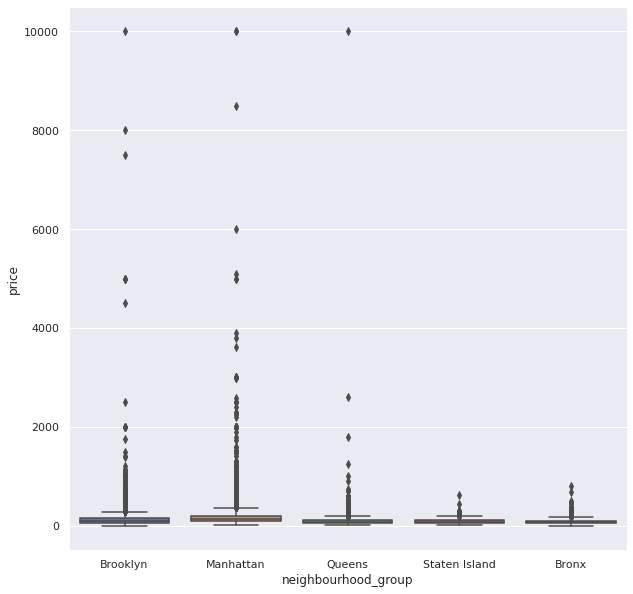

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x=X['neighbourhood_group'], y=X['price'], ax=ax)
# ax.set_ylim(0, 1500)

<AxesSubplot:xlabel='price', ylabel='Density'>

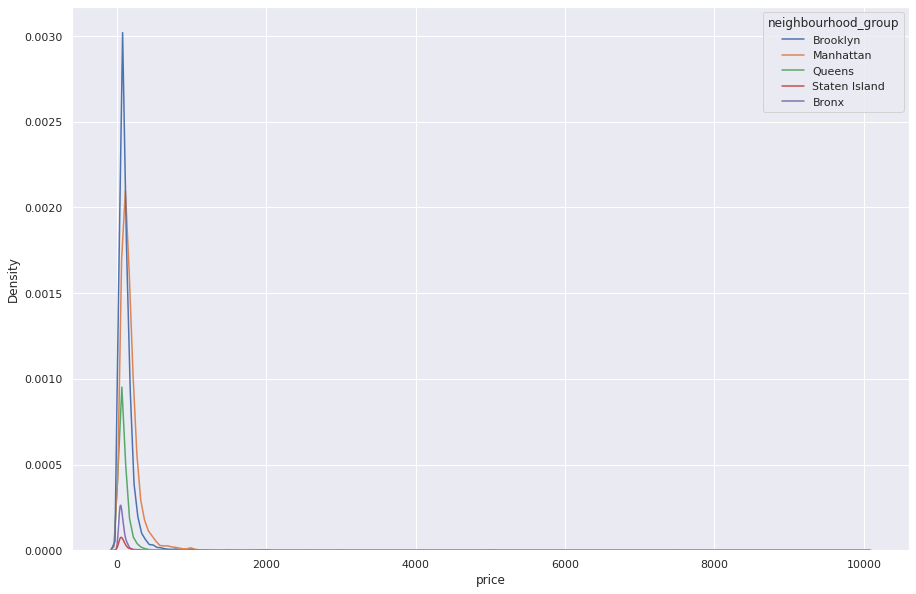

In [43]:
fig, ax = plt.subplots(figsize=(15,10))
sns.kdeplot(hue=X['neighbourhood_group'], x=X['price'], ax=ax)

In [44]:
X = X.loc[X.groupby('neighbourhood_group').apply(lambda x: x['price'] < (x['price'].std()*3)).unstack(level=0).any(axis=1)]

<AxesSubplot:xlabel='price', ylabel='Density'>

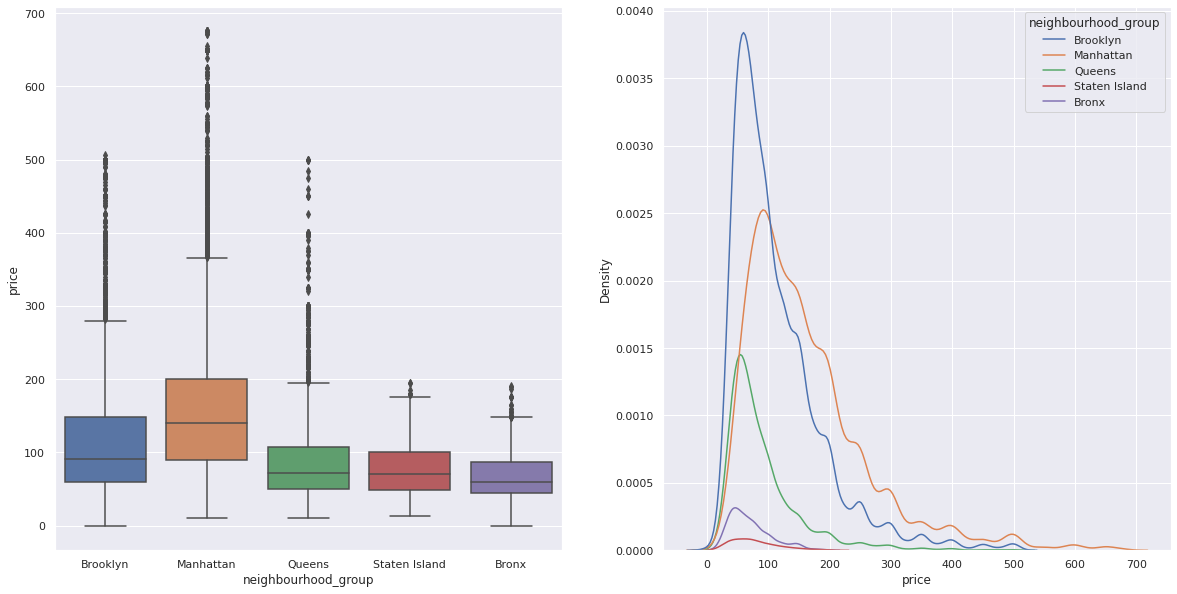

In [45]:
fig, (ax, ax_) = plt.subplots(1, 2, figsize=(20,10))
sns.boxplot(x=X['neighbourhood_group'], y=X['price'], ax=ax)
sns.kdeplot(hue=X['neighbourhood_group'], x=X['price'], ax=ax_)

In [46]:
y = X.pop('price')

X_num = X.select_dtypes(exclude='object')
X_num = X_num.drop(['id', 'host_id'], axis=1)

X_cat = X.select_dtypes(include='object')
X_cat = X_cat.drop(['name', 'host_name', 'last_review'], axis=1)
enc = OneHotEncoder()
X_enc = enc.fit_transform(X_cat).toarray()

scaler = StandardScaler()
X_std_num = scaler.fit_transform(X_num)

X_std = np.hstack((X_enc, X_std_num))
print(X_std.shape)
print(y.shape)

(38309, 232)
(38309,)


#### Train/Eval

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, train_size=0.8, random_state=42)

model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)
print(f"Train R2: {r2_score(y_train, model.predict(X_train)):.2f}")
print(f"Test R2: {r2_score(y_test, model.predict(X_test)):.2f}")

Train R2: 0.93
Test R2: 0.52


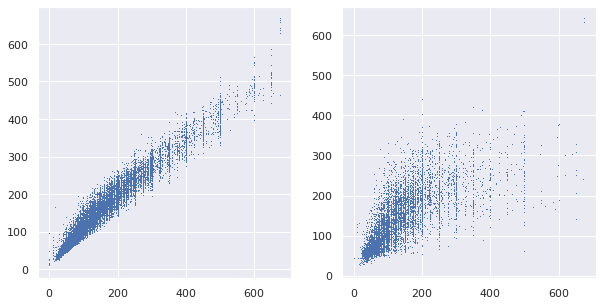

In [48]:
fig, (ax, ax_) = plt.subplots(1, 2, figsize=(10,5))
ax.plot(y_train, model.predict(X_train), ls='', marker=',')
ax_.plot(y_test, model.predict(X_test), ls='', marker=',')

### 🌟 Bin Prices, Classifier Model

In [49]:
X = airbnb.copy()
X = X.dropna(axis=0)
y = X.pop('price').values
Y = y.reshape(-1,1)

In [50]:
labels = y.copy()
labels[labels <= np.quantile(y, .25)] = 1
labels[(labels > np.quantile(y, .25)) & (labels <= np.quantile(y, .5))] = 2
labels[(labels > np.quantile(y, .5)) & (labels <= np.quantile(y, .75))] = 3
labels[(labels > np.quantile(y, .75))] = 4

In [51]:
y = labels

X_num = X.select_dtypes(exclude='object')
X_num = X_num.drop(['id', 'host_id'], axis=1)

X_cat = X.select_dtypes(include='object')
X_cat = X_cat.drop(['name', 'host_name', 'last_review'], axis=1)
enc = OneHotEncoder()
X_enc = enc.fit_transform(X_cat).toarray()

scaler = StandardScaler()
X_std_num = scaler.fit_transform(X_num)

X_std = np.hstack((X_enc, X_std_num))
print(X_std.shape)
print(y.shape)

(38821, 233)
(38821,)


#### Train/Eval

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, train_size=0.8, random_state=42)

model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train, y_train)
print(f"Train Acc: {accuracy_score(y_train, model.predict(X_train)):.2f}")
print(f"Test Acc: {accuracy_score(y_test, model.predict(X_test)):.2f}")

Train Acc: 1.00
Test Acc: 0.60


              precision    recall  f1-score   support

           1       1.00      1.00      1.00      7986
           2       1.00      1.00      1.00      7594
           3       1.00      1.00      1.00      7878
           4       1.00      1.00      1.00      7598

    accuracy                           1.00     31056
   macro avg       1.00      1.00      1.00     31056
weighted avg       1.00      1.00      1.00     31056



<AxesSubplot:>

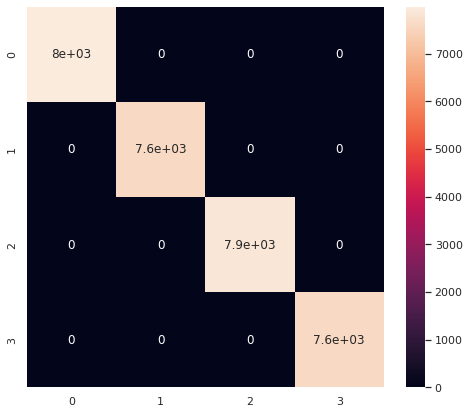

In [53]:
y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred, zero_division=0))
fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_train,y_pred), annot=True, ax=ax)

              precision    recall  f1-score   support

           1       0.70      0.80      0.74      1998
           2       0.49      0.44      0.46      1846
           3       0.50      0.47      0.48      1986
           4       0.66      0.67      0.66      1935

    accuracy                           0.60      7765
   macro avg       0.59      0.59      0.59      7765
weighted avg       0.59      0.60      0.59      7765



<AxesSubplot:>

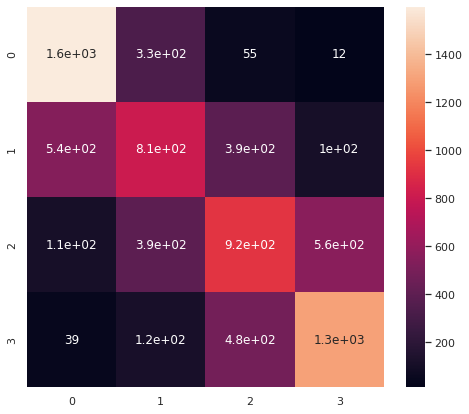

In [54]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))
fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, ax=ax)

### 👎 Cluster Prices, Classifier Model

In [55]:
X = airbnb.copy()
X = X.dropna(axis=0)
y = X.pop('price').values
Y = y.reshape(-1,1)

In [56]:
distortions = []
inertias = []
silhouette = []
variance = []
krange = 20
for k in range(1,krange):

    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Y)
    y_kmeans = kmeans.predict(Y)
    labels = kmeans.labels_

    distortions.append(sum(np.min(cdist(Y, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / Y.shape[0])
    inertias.append(kmeans.inertia_)

    if k > 1:
        silhouette.append(silhouette_score(Y, labels, metric = 'euclidean'))
        variance.append(calinski_harabasz_score(Y, labels))

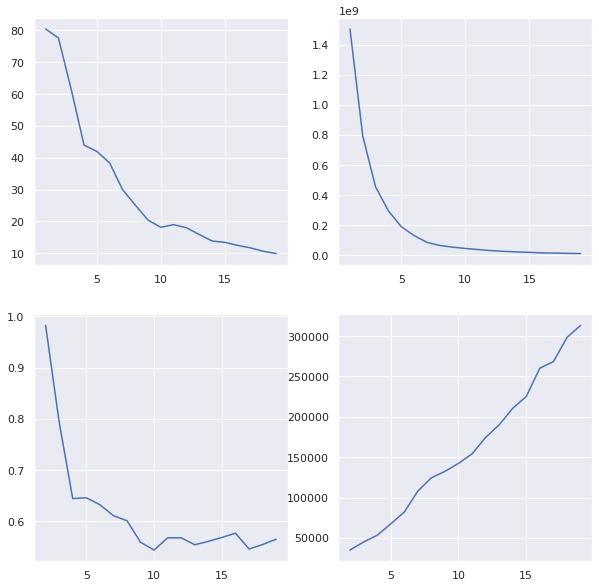

In [57]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10,10))
ax1.plot(range(1,krange), distortions)
ax2.plot(range(1,krange), inertias)
ax3.plot(range(2,krange), silhouette)
ax4.plot(range(2,krange), variance)

In [58]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(Y)
y_kmeans = kmeans.predict(Y)
labels = kmeans.labels_

In [59]:
ks = kmeans.cluster_centers_
ks = ks.flatten()
ks = np.sort(ks)
ks

array([  87.29374822,  230.74992332,  647.13125   , 2728.375     ,
       8749.75      ])

In [60]:
edges = (np.diff(ks)/2 + ks[:-1]).astype(int) 
bins = []
for idx, edge in enumerate(edges):
    if idx == 0:
        bins.append(f"0-{edge}")
    elif idx < len(edges):
        bins.append(f"{edges[idx-1]}-{edge}")
bins.append(f"{edge}+")
bins  

['0-159', '159-438', '438-1687', '1687-5739', '5739+']

In [61]:
pd.DataFrame(labels).value_counts(sort=False)

0     9651
1        8
2      961
3    28153
4       48
dtype: int64

In [62]:
y = labels

X_num = X.select_dtypes(exclude='object')
X_num = X_num.drop(['id', 'host_id'], axis=1)

X_cat = X.select_dtypes(include='object')
X_cat = X_cat.drop(['name', 'host_name', 'last_review'], axis=1)
enc = OneHotEncoder()
X_enc = enc.fit_transform(X_cat).toarray()

scaler = StandardScaler()
X_std_num = scaler.fit_transform(X_num)

X_std = np.hstack((X_enc, X_std_num))
print(X_std.shape)
print(y.shape)

(38821, 233)
(38821,)


#### Train/Eval

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, train_size=0.8, random_state=42)

model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train, y_train)
print(f"Train Acc: {accuracy_score(y_train, model.predict(X_train)):.2f}")
print(f"Test Acc: {accuracy_score(y_test, model.predict(X_test)):.2f}")

Train Acc: 1.00
Test Acc: 0.81


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7687
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00       762
           3       1.00      1.00      1.00     22561
           4       1.00      1.00      1.00        39

    accuracy                           1.00     31056
   macro avg       1.00      1.00      1.00     31056
weighted avg       1.00      1.00      1.00     31056



<AxesSubplot:>

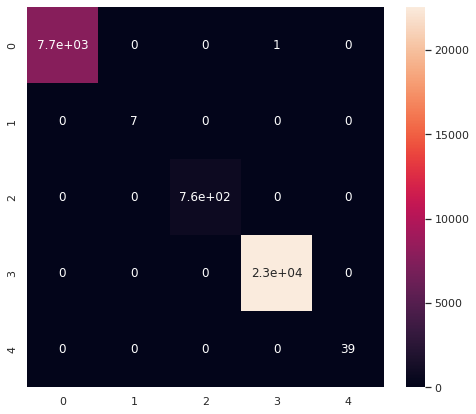

In [64]:
y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred, zero_division=0))
fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_train,y_pred), annot=True, ax=ax)

              precision    recall  f1-score   support

           0       0.64      0.60      0.62      1964
           1       0.00      0.00      0.00         1
           2       0.71      0.14      0.23       199
           3       0.86      0.91      0.88      5592
           4       0.67      0.22      0.33         9

    accuracy                           0.81      7765
   macro avg       0.58      0.37      0.41      7765
weighted avg       0.80      0.81      0.80      7765



<AxesSubplot:>

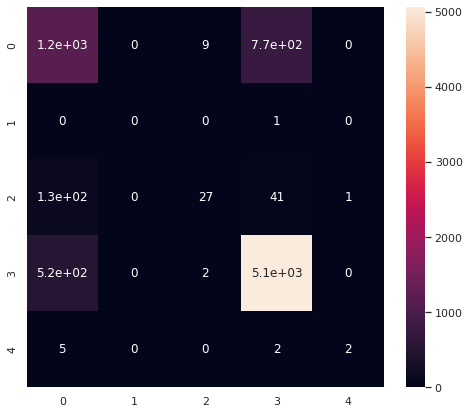

In [65]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))
fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, ax=ax)

### 🌟 PCA, Feature Reduction

The results in Bin Price, Classifier Model indicate overfitting. Let's see if we can reduce the cardinality of our One Hot features

In [143]:
X = airbnb.copy()
X = X.dropna(axis=0)
y = X.pop('price').values
Y = y.reshape(-1,1)

bins = 10
quantiles = bins + 1
labels = y.copy()
for idx, quant in enumerate(np.linspace(0,1,quantiles)):
    if idx == 0:
        prev_quant = quant
        continue
    if idx == 1:
        labels[labels <= np.quantile(y, quant)] = 1
    elif quant < 1:
        labels[(labels > np.quantile(y, prev_quant)) & (labels <= np.quantile(y, quant))] = idx
    else:
        labels[(labels > np.quantile(y, prev_quant))] = idx
    prev_quant = quant
print([np.quantile(y, quant) for quant in np.linspace(0,1,quantiles)])
y = labels

X_num = X.select_dtypes(exclude='object')
X_num = X_num.drop(['id', 'host_id'], axis=1)

X_cat = X.select_dtypes(include='object')
X_cat = X_cat.drop(['name', 'host_name', 'last_review'], axis=1)
enc = OneHotEncoder()
X_enc = enc.fit_transform(X_cat).toarray()
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_enc)
print(pca.explained_variance_)

scaler = StandardScaler()
X_std_num = scaler.fit_transform(X_num)

X_std = np.hstack((X_pca, X_std_num))
print(X_std.shape)
print(y.shape)

[0.0, 49.0, 60.0, 75.0, 90.0, 101.0, 125.0, 150.0, 190.0, 250.0, 10000.0]
[0.52595687 0.42901998 0.16673031]
(38821, 10)
(38821,)


#### Train/Eval

Train Acc: 1.00
Test Acc: 0.32
Training Confusion Matrix
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3148
           2       1.00      1.00      1.00      3241
           3       1.00      1.00      1.00      3458
           4       1.00      1.00      1.00      3075
           5       1.00      1.00      1.00      2658
           6       1.00      1.00      1.00      3198
           7       1.00      1.00      1.00      3426
           8       1.00      1.00      1.00      2759
           9       1.00      1.00      1.00      3274
          10       1.00      1.00      1.00      2819

    accuracy                           1.00     31056
   macro avg       1.00      1.00      1.00     31056
weighted avg       1.00      1.00      1.00     31056



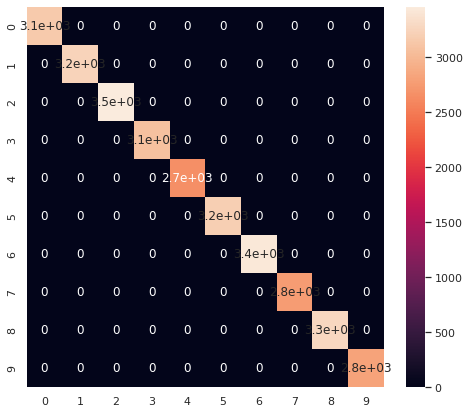

Testing Confusion Matrix
              precision    recall  f1-score   support

           1       0.51      0.56      0.54       840
           2       0.36      0.41      0.39       794
           3       0.30      0.31      0.30       824
           4       0.26      0.23      0.25       782
           5       0.17      0.15      0.16       604
           6       0.24      0.23      0.24       813
           7       0.25      0.26      0.25       842
           8       0.25      0.19      0.22       736
           9       0.32      0.35      0.33       818
          10       0.46      0.48      0.47       712

    accuracy                           0.32      7765
   macro avg       0.31      0.32      0.31      7765
weighted avg       0.32      0.32      0.32      7765



<AxesSubplot:>

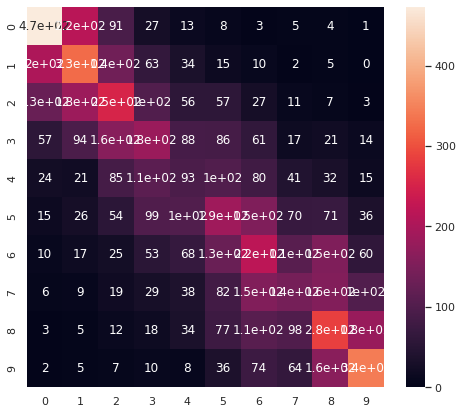

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, train_size=0.8, random_state=42)

model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train, y_train)
print(f"Train Acc: {accuracy_score(y_train, model.predict(X_train)):.2f}")
print(f"Test Acc: {accuracy_score(y_test, model.predict(X_test)):.2f}")

y_pred = model.predict(X_train)
print("Training Confusion Matrix")
print(classification_report(y_train, y_pred, zero_division=0))
fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_train,y_pred), annot=True, ax=ax)
plt.show()

y_pred = model.predict(X_test)
print("Testing Confusion Matrix")
print(classification_report(y_test, y_pred, zero_division=0))
fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, ax=ax)

### 🔮 Last Review Date, PCA for Outlier Removal, Impute

If I wanted to spend more time on this:

1. remove outliers with PCA
    * the issue with our outlier removal previously, is that we are conditioning on `y`. As we can't _know_ `y` in a production setting, this makes our model suspetible to underdetecting true, high-y value signal
    * removing outliers based on the input, `X` is prefered, and we might try this with PCA
2. turn `last_review_date` into a number (counts of days)
    * this would change a string (to be one hot encoded) column to a number column (avoids curse of dimensionality)
3. impute missing values
    * we're currently omitting about 20% of our data points, it may give us a boost to impute or otherwise estimate these missing values

## Hyperparameter Optimization

### Round 1

We'll start with a broad, shallow search (few trees)

In [70]:
param_grid = {'bootstrap': [True, False],
              'criterion': ['gini', 'entropy'],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [1, 3, 5],
              'max_features': ['auto', 'sqrt', 'log2'],
              'class_weight': ['balanced', 'balanced_subsample', None],
              'n_estimators': [1, 5]}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1, verbose=3)

In [ ]:
grid.fit(X_train, y_train)
print(grid.best_params_)

In [73]:
print(grid.best_params_)

{'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 5}


Train Acc: 0.79
Test Acc: 0.30
Training Confusion Matrix
              precision    recall  f1-score   support

           1       0.80      0.89      0.84      3148
           2       0.79      0.83      0.81      3241
           3       0.82      0.74      0.78      3458
           4       0.77      0.76      0.77      3075
           5       0.74      0.79      0.77      2658
           6       0.79      0.74      0.76      3198
           7       0.81      0.71      0.76      3426
           8       0.77      0.83      0.80      2759
           9       0.81      0.77      0.79      3274
          10       0.80      0.86      0.83      2819

    accuracy                           0.79     31056
   macro avg       0.79      0.79      0.79     31056
weighted avg       0.79      0.79      0.79     31056



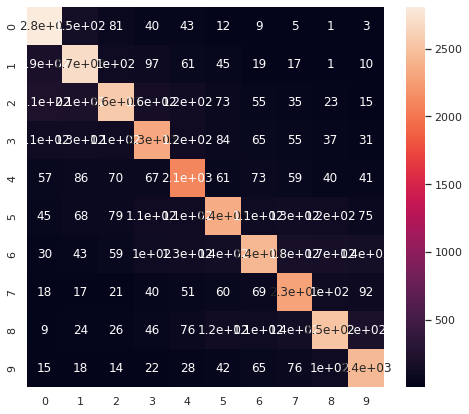

Testing Confusion Matrix
              precision    recall  f1-score   support

           1       0.49      0.58      0.53       840
           2       0.33      0.37      0.35       794
           3       0.28      0.24      0.26       824
           4       0.23      0.21      0.22       782
           5       0.17      0.21      0.18       604
           6       0.24      0.20      0.22       813
           7       0.23      0.20      0.21       842
           8       0.23      0.22      0.22       736
           9       0.29      0.27      0.28       818
          10       0.41      0.47      0.44       712

    accuracy                           0.30      7765
   macro avg       0.29      0.30      0.29      7765
weighted avg       0.29      0.30      0.29      7765



<AxesSubplot:>

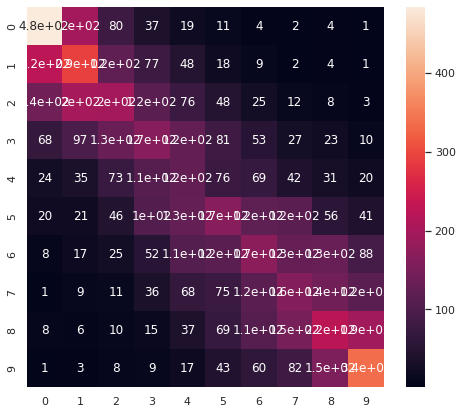

In [72]:
model = grid.best_estimator_
model.fit(X_train, y_train)
print(f"Train Acc: {accuracy_score(y_train, model.predict(X_train)):.2f}")
print(f"Test Acc: {accuracy_score(y_test, model.predict(X_test)):.2f}")

y_pred = model.predict(X_train)
print("Training Confusion Matrix")
print(classification_report(y_train, y_pred, zero_division=0))
fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_train,y_pred), annot=True, ax=ax)
plt.show()

y_pred = model.predict(X_test)
print("Testing Confusion Matrix")
print(classification_report(y_test, y_pred, zero_division=0))
fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, ax=ax)

In [116]:
gs_results = pd.DataFrame(grid.cv_results_)
params = list(gs_results.columns[gs_results.columns.str.contains('param')].values)
params.pop(-1)
display(gs_results.head())
print(params)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.118039      0.002019         0.004001        0.000212   
1       0.518118      0.006517         0.012629        0.000356   
2       0.113497      0.004069         0.003702        0.000130   
3       0.482682      0.004648         0.012108        0.000515   
4       0.104504      0.004581         0.003597        0.000109   

  param_bootstrap param_class_weight param_criterion param_max_features  \
0            True           balanced            gini               auto   
1            True           balanced            gini               auto   
2            True           balanced            gini               auto   
3            True           balanced            gini               auto   
4            True           balanced            gini               auto   

  param_min_samples_leaf param_min_samples_split  ... split0_test_score  \
0                      1                       2  ...          0.230787   
1                      1                       2  ...          0.262114   
2                      1                       4  ...          0.231463   
3                      1                       4  ...          0.268875   
4                      1                       6  ...          0.232590   

  split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0          0.235745           0.239351           0.232139           0.247520   
1          0.268425           0.253324           0.281271           0.273670   
2          0.231012           0.236196           0.249268           0.243012   
3          0.277890           0.272481           0.275186           0.275248   
4          0.227406           0.237773           0.246338           0.249549   

   split5_test_score  split6_test_score  mean_test_score  std_test_score  \
0           0.238278           0.222272         0.235156        0.007317   
1           0.272543           0.259693         0.267291        0.008820   
2           0.240532           0.229937         0.237345        0.006712   
3           0.274121           0.272543         0.273764        0.002630   
4           0.232191           0.238954         0.237829        0.007357   

   rank_test_score  
0              610  
1              309  
2              567  
3              269  
4              559  

[5 rows x 22 columns]

['param_bootstrap', 'param_class_weight', 'param_criterion', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators']


In [125]:
target = 'mean_test_score'
moodsdf = pd.DataFrame()

for col in params:
  for truff in gs_results[col].unique():
    try:
        group = gs_results.loc[gs_results[col] == truff][target]
        pop = gs_results.loc[~(gs_results[col] == truff)][target]
        stat, p, m, table = stats.median_test(group, pop)
        median = np.median(group)
        mean = np.mean(group)
        size = len(group)

        moodsdf = pd.concat([moodsdf, 
                                  pd.DataFrame([col, truff, 
                                                stat, p, m, mean, median, size,
                                                 table]).T])
    except:
        print(col, truff)
moodsdf.columns = ['descriptor', 'group', 'pearsons_chi_square', 'p_value', 
                'grand_median', 'group_mean', 'group_median', 'size', 
                'table']
moodsdf['p_value'] = moodsdf['p_value'].astype(float)
print(moodsdf.shape)

confidence_level = 0.05
moodsdf = moodsdf.loc[(moodsdf['p_value'] < confidence_level)].sort_values('group_median')

moodsdf = moodsdf.sort_values('group_median').reset_index(drop=True)
print("Clearing high p-value...")
print(moodsdf.shape)

param_class_weight None
(17, 9)
Clearing high p-value...
(2, 9)


In [120]:
moodsdf

descriptor group pearsons_chi_square        p_value grand_median  \
0  param_n_estimators     1          644.006173  4.494276e-142     0.260964   
1  param_n_estimators     5          644.006173  4.494276e-142     0.260964   

  group_mean group_median size                 table  
0   0.243444     0.243093  324  [[0, 324], [324, 0]]  
1   0.280889     0.281234  324  [[324, 0], [0, 324]]

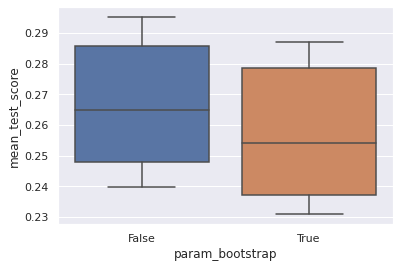

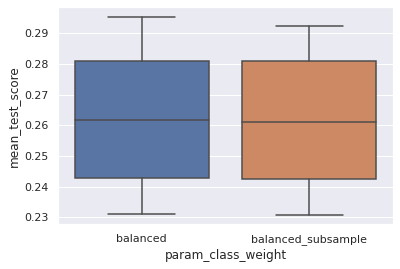

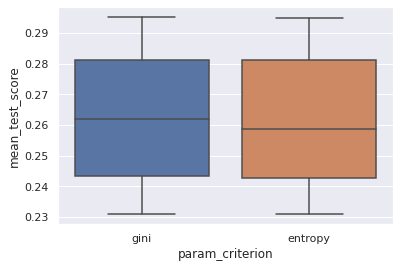

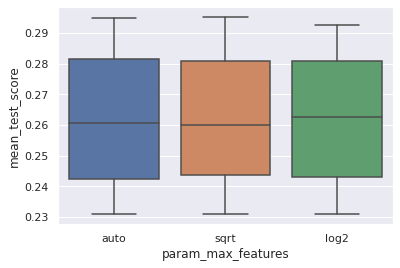

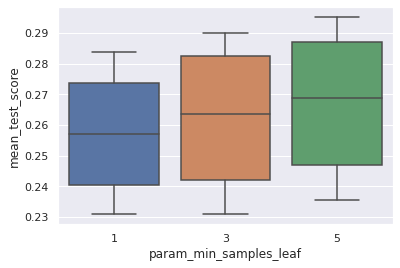

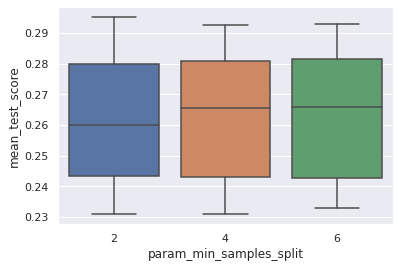

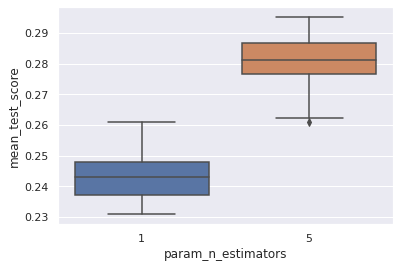

In [123]:
for param in params:
    sns.boxplot(x=gs_results[param], y=gs_results[target])
    plt.show()

### Round 2

Let's take those best parameters and dig a little deaper

In [73]:
print(grid.best_params_)

{'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 5}


In [126]:
param_grid = {'bootstrap': [True, False],
              'criterion': ['gini', 'entropy']}

grid = GridSearchCV(RandomForestClassifier(min_samples_leaf=5,
                                           min_samples_split=2,
                                           max_features='sqrt',
                                           class_weight='balanced',
                                           n_estimators=100), param_grid, cv=5, n_jobs=-1, verbose=2)

In [127]:
grid.fit(X_train, y_train)
print(grid.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'bootstrap': False, 'criterion': 'entropy'}


In [132]:
gs_results2 = pd.DataFrame(grid.cv_results_)
params = list(gs_results2.columns[gs_results2.columns.str.contains('param')].values)
params.pop(-1)
display(gs_results2.head())
print(params)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      20.133523      0.372951         0.581618        0.020547   
1      52.458941      0.532249         0.603756        0.138301   
2      31.101482      0.656385         0.763153        0.090014   
3      53.006182      7.189164         0.337193        0.088254   

  param_bootstrap param_criterion  \
0            True            gini   
1            True         entropy   
2           False            gini   
3           False         entropy   

                                         params  split0_test_score  \
0      {'bootstrap': True, 'criterion': 'gini'}           0.306825   
1   {'bootstrap': True, 'criterion': 'entropy'}           0.311494   
2     {'bootstrap': False, 'criterion': 'gini'}           0.306665   
3  {'bootstrap': False, 'criterion': 'entropy'}           0.307147   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.305909           0.309612           0.314281           0.307036   
1           0.297859           0.314925           0.312188           0.304460   
2           0.303494           0.314603           0.313798           0.302689   
3           0.303333           0.317501           0.313476           0.307841   

   mean_test_score  std_test_score  rank_test_score  
0         0.308733        0.003035                2  
1         0.308185        0.006211                4  
2         0.308250        0.005044                3  
3         0.309860        0.005010                1

['param_bootstrap', 'param_criterion']


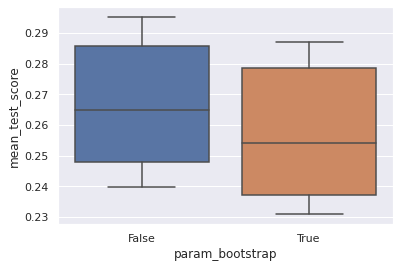

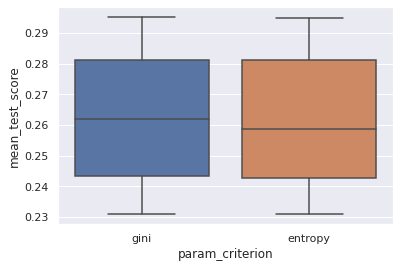

In [131]:
for param in params:
    sns.boxplot(x=gs_results[param], y=gs_results[target])
    plt.show()

### Round 3

And now tune model complexity

In [134]:
# Cell for Exercise 2
r2 = []
for n_estimators in range(10,100,10):
    model = RandomForestClassifier(n_estimators=n_estimators,
                                  bootstrap=False,
                                  criterion='entropy',
                                  min_samples_leaf=5,
                                   min_samples_split=2,
                                   max_features='sqrt',
                                   class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2.append([r2_score(y_train, model.predict(X_train)),
    r2_score(y_test, model.predict(X_test))])

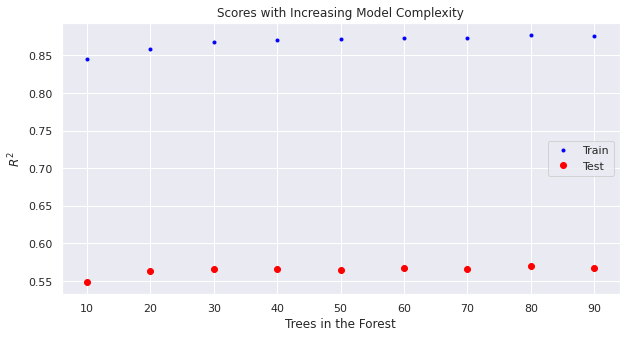

In [136]:
score = np.array(r2)
score1 = score[:,0]
score2 = score[:,1]
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(range(10,100,10), score1, ls='', marker='.', color='blue', label='Train')
ax.plot(range(10,100,10), score2, ls='', marker='o', color='red', label='Test')
ax.set_title("Scores with Increasing Model Complexity")
ax.set_xlabel("Trees in the Forest")
ax.set_ylabel("$R^2$")
ax.legend()

Train Acc: 0.90
Test Acc: 0.32
Training Confusion Matrix
              precision    recall  f1-score   support

           1       0.86      0.95      0.90      3148
           2       0.88      0.91      0.90      3241
           3       0.92      0.86      0.89      3458
           4       0.90      0.88      0.89      3075
           5       0.87      0.91      0.89      2658
           6       0.91      0.86      0.89      3198
           7       0.93      0.85      0.89      3426
           8       0.90      0.93      0.91      2759
           9       0.91      0.89      0.90      3274
          10       0.88      0.94      0.91      2819

    accuracy                           0.90     31056
   macro avg       0.90      0.90      0.90     31056
weighted avg       0.90      0.90      0.90     31056



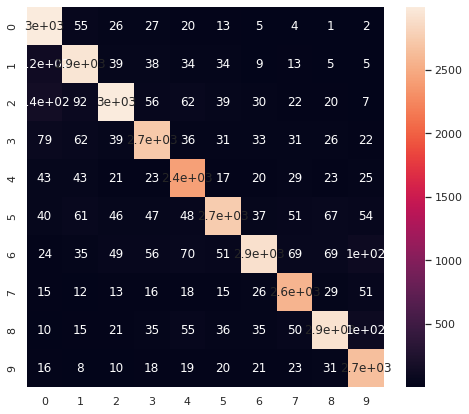

Testing Confusion Matrix
              precision    recall  f1-score   support

           1       0.51      0.60      0.55       840
           2       0.34      0.38      0.36       794
           3       0.30      0.26      0.28       824
           4       0.27      0.24      0.26       782
           5       0.17      0.21      0.19       604
           6       0.25      0.22      0.23       813
           7       0.25      0.21      0.23       842
           8       0.25      0.24      0.24       736
           9       0.33      0.30      0.31       818
          10       0.44      0.54      0.48       712

    accuracy                           0.32      7765
   macro avg       0.31      0.32      0.31      7765
weighted avg       0.31      0.32      0.32      7765



<AxesSubplot:>

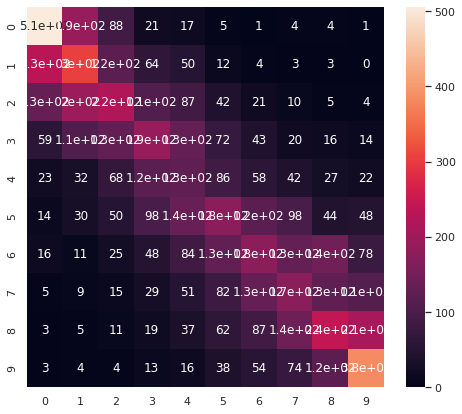

In [140]:
model = grid.best_estimator_
model.n_estimators = 80
model.fit(X_train, y_train)
print(f"Train Acc: {accuracy_score(y_train, model.predict(X_train)):.2f}")
print(f"Test Acc: {accuracy_score(y_test, model.predict(X_test)):.2f}")

y_pred = model.predict(X_train)
print("Training Confusion Matrix")
print(classification_report(y_train, y_pred, zero_division=0))
fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_train,y_pred), annot=True, ax=ax)
plt.show()

y_pred = model.predict(X_test)
print("Testing Confusion Matrix")
print(classification_report(y_test, y_pred, zero_division=0))
fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, ax=ax)

After all that work we don't get much lift from the random forest with default hyperparameters

## Conclusion

### The Final Classification Model

Final model had an F1 score ranging from 19-55% depending on class and a total accuracy of 32%

This model could be used to suggest a price band for would-be airbnb hosts in NYC; or a price estimator to assess how changes in listing attributes wil affect price. A potential pitfall could be that new airbnb hosts will not have many total reviews or high variance in the reviews per month.

We can currate price signal from the available feature inputs:

* `neighbourhood_group`
* `neighbourhood`
* `longitude`/`latitude`
* `room_type`
* `price`
* `minimum_nights`
* `number_of_reviews`
* `reviews_per_month`
* `calculated_host_listings_count`
* `availability_365`

What worked:

* dropping nans row-wise allowed us to keep the `reviews_per_month` column, which gave us an \\(R^2\\) boost of 10%
* converting from a regression problem to a classification problem allowed us to deal with the long, high-price tail
* converting one hot encoded vectors to the first principal components kept us from overfitting (although this was not important for the random forrest model)

More to try:

* change `last_review_date` from `datetime` or `str` to `int`
* use PCA for outlier removal based on the input data `X`
* imput missing values for `reviews_per_month` to capture an additional 10,000 datapoints

### Additional Strategies

Removing outliers based on the target variable, `price`, could also be a valid strategy. If we were to employ the model, we would have to be transparent that it should be used to predict prices in the sub $700 range, which is most of the Airbnb business in NYC anyway. At the end of the day, our decisions about model creation need to serve the business need. 